In [5]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cmocean
import sys
import os

In [76]:
datpath = "../../CESM_data/"
outpath = "../../Figures/" # output directory
vnames = ['sst','sss','psl']
vnamelong = ["Sea Surface Temperature (degC)","Sea Surface Salinity (psu)","Sea Level Pressure (hPa)"]
resolution = '2deg'
season = 'Ann'

sys.path.append("../")
import amvmod as amv

cmap = cmocean.cm.balance

In [80]:
def calc_AMV_index(region,invar,lat,lon):
    """
    Select bounding box for a given AMV region for an input variable
        "SPG" - Subpolar Gyre
        "STG" - Subtropical Gyre
        "TRO" - Tropics
        "NAT" - North Atlantic
    
    Parameters
    ----------
    region : STR
        One of following the 3-letter combinations indicating selected region
        ("SPG","STG","TRO","NAT")
        
    var : ARRAY [Ensemble x time x lat x lon]
        Input Array to select from
    lat : ARRAY
        Latitude values
    lon : ARRAY
        Longitude values    

    Returns
    -------
    amv_index [ensemble x time]
        AMV Index for a given region/variable

    """
    
    # Select AMV Index region
    bbox_SP = [-60,-15,40,65]
    bbox_ST = [-80,-10,20,40]
    bbox_TR = [-75,-15,0,20]
    bbox_NA = [-80,0 ,0,65]
    regions = ("SPG","STG","TRO","NAT")        # Region Names
    bboxes = (bbox_SP,bbox_ST,bbox_TR,bbox_NA) # Bounding Boxes
    
    # Get bounding box
    bbox = bboxes[regions.index(region)]
    
    # Select Region
    selvar = invar.copy()
    klon = np.where((lon>=bbox[0]) & (lon<=bbox[1]))[0]
    klat = np.where((lat>=bbox[2]) & (lat<=bbox[3]))[0]
    selvar = selvar[:,:,klat[:,None],klon[None,:]]
    
    # Take mean ove region
    amv_index = np.nanmean(selvar,(2,3))
    
    return amv_index

def deseason_lazy(ds,return_scycle=False):
    """
    Deseason function without reading out the values. Remove the seasonal cycle by subtracting the monthly anomalies
    Input:
        ds : DataArray
            Data to be deseasoned
        return_scycle : BOOL (Optional)
            Set to true to return the seasonal cycle that was removed
    Output:
        data_deseason : DataArray
            Deseasoned data
    
    """
    data_deseason = ds.groupby('time.month') - ds.groupby('time.month').mean('time')
    
    if return_scycle:
        return data_deseason,ds.groupby('time.month').mean('time')
    return data_deseason

def plot_box(bbox,ax=None,return_line=False,leglab="Bounding Box",color='k',linestyle='solid',linewidth=1):
    
    """
    Plot bounding box
    Inputs:
        1) bbox [1D-ARRAY] [lonW,lonE,latS,latN]
        Optional Arguments...
        2) ax           [axis] axis to plot onto
        3) return_line  [Bool] return line object for legend labeling
        4) leglabel     [str]  Label for legend
        5) color        [str]  Line Color, default = black
        6) linestyle    [str]  Line style, default = solid
        7) linewidth    [#]    Line width, default = 1  
    
    
    """
    if ax is None:
        ax = plt.gca()
    # Plot North Boundary
    ax.plot([bbox[0],bbox[1]],[bbox[3],bbox[3]],color=color,ls=linestyle,lw=linewidth,label='_nolegend_')
    # Plot East Boundary
    ax.plot([bbox[1],bbox[1]],[bbox[3],bbox[2]],color=color,ls=linestyle,lw=linewidth,label='_nolegend_')
    # Plot South Boundary
    ax.plot([bbox[1],bbox[0]],[bbox[2],bbox[2]],color=color,ls=linestyle,lw=linewidth,label='_nolegend_')
    # Plot West Boundary
    ax.plot([bbox[0],bbox[0]],[bbox[2],bbox[3]],color=color,ls=linestyle,lw=linewidth,label='_nolegend_')
    
    if return_line == True:
        linesample =  ax.plot([bbox[0],bbox[0]],[bbox[2],bbox[3]],color=color,ls=linestyle,lw=linewidth,label=leglab)
        return ax,linesample
    return ax

def preprocess_obs(ds,bbox,timebnds,remove_seasonal_cycle=False):
    """
    Reads in dataarray and does the following
        1. Restricts to time/region
        2. Reads out from DataArray
        3. Removes seasonal cycle
        4. Computes annual mean
        5. calculates mean and stdev at each point
    
    input
    -----
        1. ds [DataArray] of variable with dimensions [lat x lon x time]
        2. bbox [Array] of bounding box [lonW,lonE,latS,latN]
        3. timebnds [Array] of strings (YYYY-MM-DD) [start , end]
        4. remove_seasonal_cycle [BOOL] set to True to remove seasonal cycle
        
    output
    ------
        1. varout [Array] Processed variable [lat x lon x time]
        2. varstd [Array] Standard deviation at each point [lat x lon x time]
        3. varmean [Array] Mean at each point [lat x lon x time]
        
    
    """
    dst = ds.sel(time=slice(timebnds[0],timebnds[1])) # Select time slice
    dsr = dst.sel(lat=slice(bbox[2],bbox[3]),lon=slice(bbox[0],bbox[1])) # Select region
    readout = dsr.values
    nlat,nlon,ntime = readout.shape
    print(readout.shape)
    varout = readout.reshape(nlat,nlon,int(ntime/12),12)
    if remove_seasonal_cycle:
        varout = varout - varout.mean(2)[:,:,None,:]
    varout = varout.mean(3)
    
    
    varstd = varout.std(2)
    varmean = varout.mean(2)
    return varout,varstd,varmean

In [11]:
# Load latitude longitude
lon = np.load("../../CESM_data/lon_%s_NAT.npy"%(resolution))
lat = np.load("../../CESM_data/lat_%s_NAT.npy"%(resolution))

In [59]:
# %%time

# resolution = '2deg'
# season = 'Ann'

# # Load in the data
# sst_normed = np.load('../../CESM_data/CESM_sst_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
# sss_normed = np.load('../../CESM_data/CESM_sss_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)
# psl_normed = np.load('../../CESM_data/CESM_psl_normalized_lat_weighted_%s_NAT_%s.npy' % (resolution,season)).astype(np.float32)

# # Calculate AMV Indices
# regions  = ["NAT","SPG","STG","TRO"]

# amvindices = []
# for region in regions:
#     sst_ensemble = calc_AMV_index(region,sst_normed[:,:,:,:],lat,lon)
#     amvindices.append(sst_ensemble)
#     print("Calculated AMV for %s"%region)
    
    



NameError: name 'lat' is not defined

In [12]:
# %%time

# # Calculate mean and standard deviation
# climmn  = []
# climstd = []
# varraw  = []
# bbox       = [-80,0,0,65] # NAT

# for vname in vnames:
    
#     # Open the dataset
#     ds = xr.open_dataset("../../CESM_data/CESM1LE_%s_NAtl_19200101_20051201_Regridded2deg.nc"% (vname))[vname]
    
#     # 2) Select Region
#     dsreg = ds.sel(lon=slice(bbox[0],bbox[1]),lat=slice(bbox[2],bbox[3]))
    
#     # 4) Deseason the data
#     data_deseason,scycle = deseason_lazy(dsreg,return_scycle=True)
    
#     # 5) Read out the data
#     dsout = data_deseason.values # [Lat x Lon x Time x Ensemble]
    
#     # 6) Select months and take the average (for annual resolution)
#     nlat,nlon,ntime,nens = dsout.shape
#     dsout = dsout.reshape(nlat,nlon,int(ntime/12),12,nens)
#     dsout = dsout[:,:,:,month_id,:].mean(3)
    
#     # Calculate standard deviation
#     climstd.append(np.nanstd(dsout,2,3))
#     climmn.append(np.nanmean(dsout,2,3))
#     varraw.append(dsout.copy())
    
#     print("Done with %s"%vname)

In [45]:
# Read in reanalysis datasets
sst = xr.open_dataset("../../CESM_data/HadISST_sst_NAtl_18700101_20181201_Regridded2deg.nc")['sst']
psl = xr.open_dataset("../../CESM_data/NOAA20CR_psl_NAtl_18510101_20141201_Regridded2deg.nc")['psl']
sss = xr.open_dataset("../../CESM_data/CGLORSv5_sss_NAtl_19800115_20160101_Regridded2deg.nc")['sss']

In [47]:
%%time
dsall = [sst,sss,psl]
# Calculate mean and standard deviation for reanalysis
climmn  = []
climstd = []
varraw  = []
bbox     = [-80,0,0,65] # NAT

for v in range(len(vnames)):
    if v == 1:
        timebnds = [r"1980-02-01",r"2016-01-31"]
    else:
        timebnds = [r"1980-01-01",r"2013-12-31"]
    a = preprocess_obs(dsall[v],bbox,timebnds)
    
    # Calculate standard deviation
    climstd.append(a[1])
    climmn.append(a[2])
    varraw.append(a[0])
    
    print("Done with %s"%v)

(33, 41, 408)
Done with 0
(33, 41, 432)
Done with 1
(33, 41, 408)
Done with 2
CPU times: user 109 ms, sys: 10.2 ms, total: 120 ms
Wall time: 118 ms


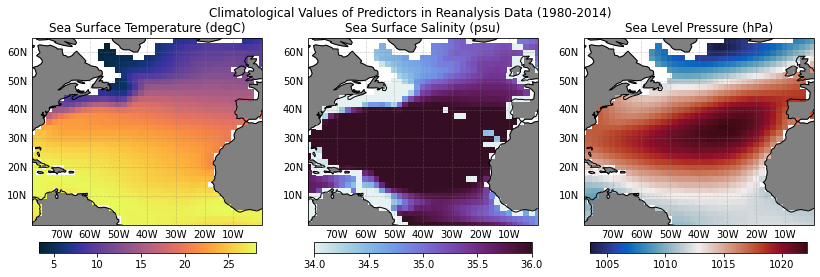

In [78]:


fig,axs=plt.subplots(1,3,figsize=(14,4),subplot_kw={'projection':ccrs.PlateCarree()})

varplot = climmn


v = 0
ax = axs[v]
ax = amv.init_map(bbox,ax=ax)
pcm1 = ax.pcolormesh(lon,lat,varplot[v],cmap=cmocean.cm.thermal)
ax.set_title(vnamelong[v])
fig.colorbar(pcm1,ax=ax,fraction=0.05,orientation='horizontal',pad=0.08)
ax.add_feature(cfeature.LAND,facecolor='gray')


v = 1
ax = axs[v]
ax = amv.init_map(bbox,ax=ax)
pcm2 = ax.pcolormesh(lon,lat,varplot[v],vmin=34,vmax=36,cmap=cmocean.cm.dense)
ax.set_title(vnamelong[v])
fig.colorbar(pcm2,ax=ax,fraction=0.05,orientation='horizontal',pad=0.08)
ax.add_feature(cfeature.LAND,facecolor='gray')

v = 2
ax = axs[v]
ax = amv.init_map(bbox,ax=ax)
pcm3 = ax.pcolormesh(lon,lat,varplot[v]/100,cmap=cmocean.cm.balance)
ax.set_title(vnamelong[v])
fig.colorbar(pcm3,ax=ax,fraction=0.05,orientation='horizontal',pad=0.08)
ax.add_feature(cfeature.LAND,facecolor='gray')

plt.suptitle("Climatological Values of Predictors in Reanalysis Data (1980-2014)")
#plt.tight_layout()
plt.savefig(outpath+"Fig01_Top_ClimPlots.png",dpi=200)

In [37]:
np.nanstd(climstd[1])

50.206465489332516

In [111]:
# Plot AMV Pattern
sstout,_,_ = preprocess_obs(sst,bbox,['1900-01-01','2018-12-01'],remove_seasonal_cycle=True)
sstout = sstout.transpose(2,0,1) # Transpose to [ens time lat lon]


# Calculate AMV Indices for Each Region
# Calculate AMV Indices
regions  = ["NAT","SPG","STG","TRO"]

amvindices = []
for region in regions:
    sst_ensemble = calc_AMV_index(region,sstout[None,:,:,:],lat,lon)
    amvindices.append(sst_ensemble)
    print("Calculated AMV for %s"%region)

(33, 41, 1428)
Calculated AMV for NAT
Calculated AMV for SPG
Calculated AMV for STG
Calculated AMV for TRO


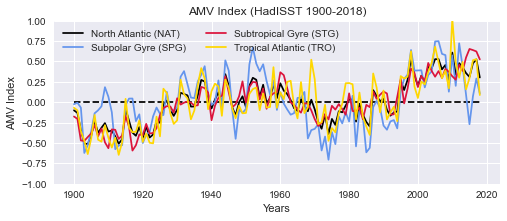

In [114]:
# Plot AMV Indices
y = np.arange(1900,2019,1)
scolors  = ["black","cornflowerblue","crimson","gold"]
slongname = ["North Atlantic (NAT)","Subpolar Gyre (SPG)","Subtropical Gyre (STG)","Tropical Atlantic (TRO)"]


fig,ax = plt.subplots(1,1,figsize=(8,3))
plt.style.use('seaborn')
plt.hlines(0,y[0],y[-1],linestyle='dashed',color='k')
for r in range(4):
    ax.plot(y,amvindices[r].squeeze(),label=slongname[r],color=scolors[r])
ax.legend(ncol=2)

ax.set_xlabel("Years")
ax.set_ylabel("AMV Index")
ax.set_ylim([-1,1])
ax.set_title("AMV Index (HadISST 1900-2018)")

plt.savefig(outpath+"AMV_Index_regional.png",dpi=200)
    

In [97]:
y.shape

(148,)